In [19]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from project_utils import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

%matplotlib inline

Global parameters to be tweaked are in the next cell. These are necessary both for training and test.

In [20]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (8, 8) # Spatial binning dimensions
hist_bins = 8    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [21]:
# Read in cars and notcars
images = glob.glob('../vehicles/KITTI*/*.png')
cars = []
for image in images:
    cars.append(image)
images = glob.glob('../non-vehicles/*/*.png')
notcars = []
for image in images:
    notcars.append(image)

In [22]:
t1 = time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t1, 2), 'Seconds to extract features...')

62.51 Seconds to extract features...


In [23]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler=StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Check the training time for the SVC
t3=time.time()
# Use a linear SVC 
svc = LinearSVC()
svc.fit(X_train, y_train)
t4 = time.time()
print(round(t4-t3, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5508
22.8 Seconds to train SVC...
Test Accuracy of SVC =  0.9953


In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
clip = VideoFileClip('../test_video.mp4')
images = []
for image in clip.iter_frames():
    images.append(image)

In [24]:
imagefiles = ['../test_images/test1.jpg',
          '../test_images/test2.jpg',
          '../test_images/test3.jpg',
          '../test_images/test4.jpg',
          '../test_images/test5.jpg',
          '../test_images/test6.jpg']
images = []
for imagefile in imagefiles:
    images.append(mpimg.imread(imagefile))

In [27]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, xstop, scale, step = 2):
 
    # Following globals are available
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255 # Has been scaled prior to function call
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = step  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    bbox_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = []
            if hog_feat == True:
                if hog_channel == 0:
                    hog_features = hog_feat1 #
                elif hog_channel == 1:
                    hog_features = hog_feat2
                elif hog_channel == 2:
                    hog_features = hog_feat3
                elif hog_channel == 'ALL':
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = []
            hist_features = []
            if spatial_feat:
                spatial_features = bin_spatial(subimg, size=spatial_size)
            if hist_feat:
                hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                left_top = (xbox_left+xstart, ytop_draw+ystart)
                right_bottom = (xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)
                bbox_list.append((left_top, right_bottom))
                    
    return bbox_list


In [ ]:
# Junk stuff here, don't run this cell
    bbox_list = find_cars(image, 400, 650, 950, 1280, 2.0)
    bbox_list += find_cars(image, 400, 500, 950, 1280, 1.5)
    bbox_list += find_cars(image, 400, 650, 0, 330, 2.0)
    bbox_list += find_cars(image, 400, 500, 0, 330, 1.5)
    bbox_list += find_cars(image, 400, 460, 330, 950, 0.75,3)


[((832, 432), (896, 496)), ((864, 432), (928, 496)), ((48, 424), (144, 520)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((840, 424), (936, 520)), ((1056, 400), (1152, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1120, 400), (1248, 528))]
[]
[((896, 400), (960, 464)), ((864, 400), (960, 496))]
[((864, 400), (928, 464)), ((864, 416), (928, 480)), ((864, 432), (928, 496)), ((880, 416), (944, 480)), ((816, 400), (912, 496)), ((840, 400), (936, 496)), ((840, 424), (936, 520)), ((1104, 424), (1200, 520)), ((1128, 400), (1224, 496)), ((800, 400), (928, 528)), ((832, 400), (960, 528)), ((1120, 400), (1248, 528)), ((1120, 432), (1248, 560))]
[((864, 400), (928, 464)), ((864, 416), (928, 480)), ((864, 432), (928, 496)), ((1120, 400), (1184, 464)), ((0, 424), (96, 520)), ((120, 424), (216, 520)), ((312, 448), (408, 544)), ((480, 448), (576, 544)), ((672, 424), (768, 520)), ((672, 448), (768, 544)), ((744, 400), (840, 496)), ((816, 400), (912, 496)), ((840, 400), (936, 49

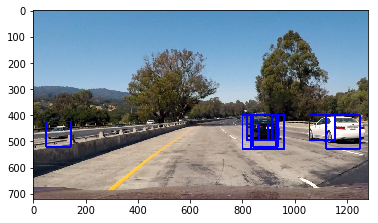

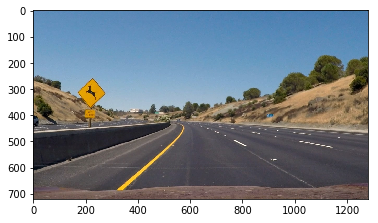

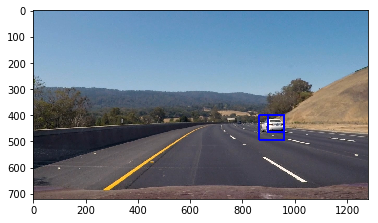

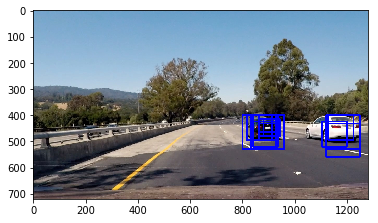

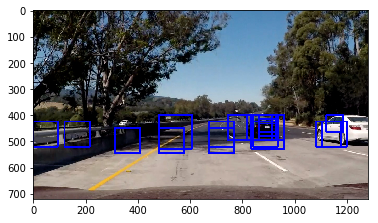

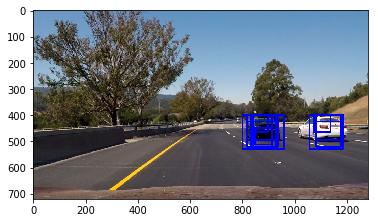

In [39]:
from project_utils import *
integration_length = 1
heat_history = [None for ii in range(integration_length)]
ind = 0
thresh_bblist = []
for image in images:
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    bbox_list = []
    for scale in [1,1.5,2]:
        bblist = find_cars(image, 400, 656,0,1280,scale)
        bbox_list = bbox_list + bblist
    for oldbb in thresh_bblist:
        center = ((oldbb[0][0]+oldbb[1][0])/2,(oldbb[0][1]+oldbb[1][1])/2)
        width  = ((oldbb[1][0]-oldbb[0][0]),(oldbb[1][1]-oldbb[1][0]))
        scale = 64/width
        print(bbox_list)

    current_heat = np.zeros_like(image[:,:,0]).astype(np.float)
    current_heat = add_heat(current_heat,bbox_list)
    
    if ind == 0:
        heat = np.copy(current_heat)
    elif ind < integration_length:
        heat += current_heat
    else:
        heat -= heat_history[ind % integration_length]
        heat += current_heat
    heat_history[ind % integration_length] = np.copy(current_heat)
        
    heat = apply_threshold(heat,1)         
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_image1 = draw_boxes(draw_image,bbox_list)
    draw_image, thresh_bblist = draw_labeled_bboxes(draw_image, labels)
    #cv2.imshow('image',draw_image1)
    #cv2.waitKey(0)
    #plt.figure()
    plt.figure()
    plt.imshow(draw_image1)
    #plt.imshow(heatmap,cmap = 'hot')
    ind += 1

In [42]:
print(np.array(((1,2),(3,4))))

[[1 2]
 [3 4]]
